## Модули

In [1]:
# Модель
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Отображение
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Загрузка датасетов

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def make_predictions(model, X_test):
    # Загрузка сбалансированного датасета
    balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]

    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   
    model.fit(X, y)
    preds = model.predict(X_test)

    save_submission(preds, 'submission')
    
def save_submission(preds, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train для удаления выбросов только из тренировочной выборки
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Тесты

In [3]:
# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры модели
parameters = {
    'objective': 'binary',
    'force_col_wise': True,
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor()
model = LGBMClassifier(**parameters, n_jobs=-1)

# Пайплайн
pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

### Кросс-валидация

In [ ]:
# Запуск кросс-валидации
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean CV: {cv_scores.mean()}')

### Валидация на тестовой выборке

In [4]:
# Обучение модели и получение предсказаний для тестовой выборки
pipeline.fit(X_res, y_res)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 169286, number of negative: 169286
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 338572, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


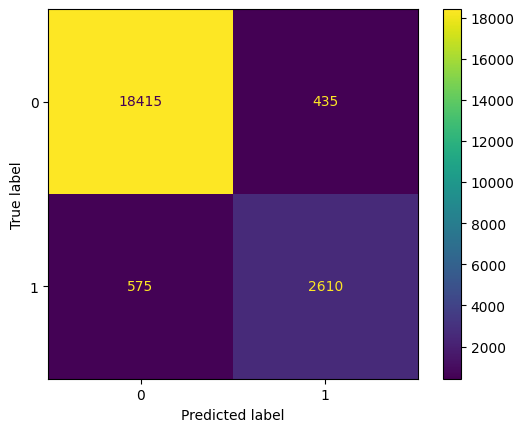

              precision    recall  f1-score   support

           0    0.96972   0.97692   0.97331     18850
           1    0.85714   0.81947   0.83788      3185

    accuracy                        0.95416     22035
   macro avg    0.91343   0.89819   0.90559     22035
weighted avg    0.95345   0.95416   0.95373     22035

F1-macro: 0.9055949439899009
ROC-AUC score: 0.8981946624803767
Accuracy: 0.9541638302700249


In [5]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

### Важность признаков

In [ ]:
feature_importances = pd.DataFrame({'Feature': pipeline['model'].feature_name_, 'Importance': pipeline['model'].feature_importances_})
feature_importances.to_csv('features.csv', index=False)

## Финальный фит-предикт

In [ ]:
# Предсказание для тестовой выборки AI Challenge
make_predictions(pipeline, test_df)